### Описание проекта

#### Описание задачи

Нужно разобраться, как ведут себя пользователи мобильного приложения, которое продаёт продукты питания

#### Описание данных

`EventName` — название события

`DeviceIDHash` — уникальный идентификатор пользователя

`EventTimestamp` — время события

`ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

#### План работы

- Загрузка данных
- Подготовка данных
- Изучение и проверка данных
- Изучение воронки событий
- Изучение результатов эксперимента

### Загрузка данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
import numpy as np
import math as mth

#### Открытие файла с данными и изучение общей информации

In [2]:
data = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


*Промежуточные результаты*

Названия столбцов необходимо привести к соответствующему формату. Столбец `EventTimestamp` необходимо привести к соответствующему формату и типу данных

### Подготовка данных

#### Обработка дубликатов

In [3]:
def missed(data):
    print(f'В таблице {round((data.duplicated().sum() / len(data)) * 100, 2)}% дубликатов')
    print()
    for column in data:
        print(f'В столбце {column} {round((data[column].isna().sum())*100, 2)}% пропущенных значений')

In [4]:
missed(data)

В таблице 0.17% дубликатов

В столбце EventName 0% пропущенных значений
В столбце DeviceIDHash 0% пропущенных значений
В столбце EventTimestamp 0% пропущенных значений
В столбце ExpId 0% пропущенных значений


Процент дубликатов значений незначителен. Дубликаты можно удалить, пропусков не обнаружено

In [5]:
data = data.drop_duplicates()
missed(data)

В таблице 0.0% дубликатов

В столбце EventName 0% пропущенных значений
В столбце DeviceIDHash 0% пропущенных значений
В столбце EventTimestamp 0% пропущенных значений
В столбце ExpId 0% пропущенных значений


*Промежуточный вывод*

Дубликаты удалены

#### Приведение названий столбцов к необходимому формату

In [6]:
data.columns

Index(['EventName', 'DeviceIDHash', 'EventTimestamp', 'ExpId'], dtype='object')

In [7]:
data.columns = ['event_name', 'device_id_hash', 'event_timestamp', 'exp_id']
data.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

*Промежуточный вывод*

Названия столбцов приведены к соответствующему формату

#### Работа со столбцом даты

In [8]:
data['event_datetime'] = pd.to_datetime(data['event_timestamp'], unit='s')
data['event_date'] = data['event_datetime'].dt.date
data.head()

,event_name,device_id_hash,event_timestamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


*Промежуточный вывод*

Необходимые столбцы с датой добавлены

*Вывод*

Произведена предобработка данных: удалены дубликаты, изменены названия столбцов, добавлены необходимые столбцы добавлены

### Изучение и подготовка данных

#### Количество событий в логе

In [9]:
events = len(data)
events

243713

*Вывод*

Всего в логе 243713 событий

#### Количество пользователей в логе

In [10]:
users = len(data['device_id_hash'].unique())
users

7551

*Вывод*

Всего в логе 7551 уникальных пользователей

#### Количество событий на пользователя

In [11]:
events_per_user = round(events / users, 1)
events_per_user

32.3

*Вывод*

На одного пользователя приходится примерно 32 события

#### Оценка распределения пользователей по группам

In [12]:
a_users = data.query('exp_id == 246')['device_id_hash']
b_users = data.query('exp_id == 247')['device_id_hash']
c_users = data.query('exp_id == 248')['device_id_hash']

print(f'В первой группе {len(a_users.unique())} уникальных пользователей')
print(f'Во второй группе {len(b_users.unique())} уникальных пользователей')
print(f'В третьей группе {len(c_users.unique())} уникальных пользователей')

print()

print(f'В первой группе {a_users[(a_users.isin(c_users) == True) | (a_users.isin(b_users) == True)].count()} пользователей, которые есть и в других группах')
print(f'Во второй группе {b_users[(b_users.isin(c_users) == True) | (b_users.isin(a_users) == True)].count()} пользователей, которые есть и в других группах')
print(f'В третьей группе {c_users[(c_users.isin(a_users) == True) | (c_users.isin(b_users) == True)].count()} пользователей, которые есть и в других группах')

В первой группе 2489 уникальных пользователей
Во второй группе 2520 уникальных пользователей
В третьей группе 2542 уникальных пользователей

В первой группе 0 пользователей, которые есть и в других группах
Во второй группе 0 пользователей, которые есть и в других группах
В третьей группе 0 пользователей, которые есть и в других группах


*Вывод*

Нет пользователей, участвующих в нескольких группах одновременно

#### Актуализация данных

##### Определения периода наблюдений

In [13]:
print(f'Минимальная дата события: {data["event_date"].min()}, максимальная дата события {data["event_date"].max()}')

Минимальная дата события: 2019-07-25, максимальная дата события 2019-08-07


*Промежуточный вывод*

Мы распологаем данными за 14 дней

##### Оценка распределения общего количества событий в группах

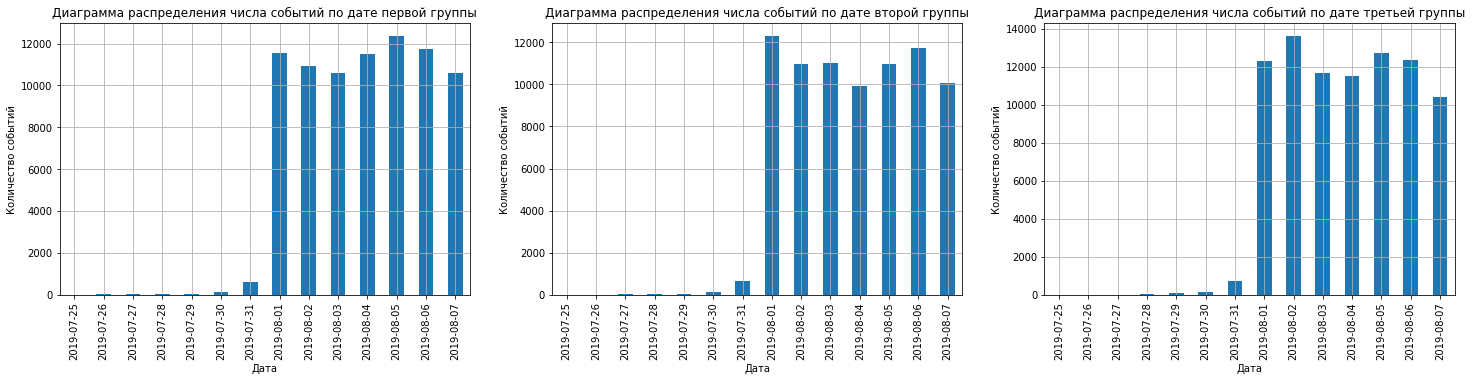

In [14]:
a_users = data.query('exp_id == 246').groupby('event_date')['device_id_hash'].count()
b_users = data.query('exp_id == 247').groupby('event_date')['device_id_hash'].count()
c_users = data.query('exp_id == 248').groupby('event_date')['device_id_hash'].count()

plt.figure(figsize=(25, 5))


a_users.plot.bar(grid=True, ax=plt.subplot(1, 3, 1))
plt.title('Диаграмма распределения числа событий по дате первой группы')
plt.xlabel('Дата')
plt.ylabel('Количество событий')


b_users.plot.bar(grid=True, ax=plt.subplot(1, 3, 2))
plt.title('Диаграмма распределения числа событий по дате второй группы')
plt.xlabel('Дата')
plt.ylabel('Количество событий')


c_users.plot.bar(grid=True, ax=plt.subplot(1, 3, 3))
plt.title('Диаграмма распределения числа событий по дате третьей группы')
plt.xlabel('Дата')
plt.ylabel('Количество событий')

None

*Промежуточный вывод*

По всем трём группам данных с 2019-07-25 по 2019-08-01 недостаточно для анализа. Мы располагаем полными данными только за 7 дней

##### Очистка данных

In [15]:
initial_data = len(data)
data = data.query('event_date > @pd.to_datetime("2019-07-31")')

print(f'После очистки данных мы потеряли {initial_data - len(data)} строк данных, что составляет {round((initial_data - len(data))*100 / initial_data)}% от общего количества пользователей')

n_a_users = len(data.query('exp_id == 246')['device_id_hash'].unique())
n_b_users = len(data.query('exp_id == 247')['device_id_hash'].unique())
n_c_users = len(data.query('exp_id == 248')['device_id_hash'].unique())

print()

print(f'После очистки данных осталось {n_a_users} пользователей первой группы')
print(f'После очистки данных осталось {n_b_users} пользователей второй группы')
print(f'После очистки данных осталось {n_c_users} пользователей третьей группы')

После очистки данных мы потеряли 2826 строк данных, что составляет 1% от общего количества пользователей

После очистки данных осталось 2484 пользователей первой группы
После очистки данных осталось 2513 пользователей второй группы
После очистки данных осталось 2537 пользователей третьей группы


*Промежуточный вывод*

Данные за неактульный период составляют 1% от общего количества данных, поэтому их можно удалить. После очистки данных в относительно равном соотношении остались пользователи всех групп

*Вывод*

Данные актуализированны

### Изучение воронки событий

#### Количество уникальных событий

In [16]:
data['event_name'].unique()

array(['Tutorial', 'MainScreenAppear', 'OffersScreenAppear',
       'CartScreenAppear', 'PaymentScreenSuccessful'], dtype=object)

*Промежуточный вывод*

Всего в данных 5 видов событий

#### Оценка частоты встречаемости событий

In [17]:
data['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

*Промежуточный вывод*

Наиболее часто встречающимся является событие MainScreenAppear

#### Оценка частоты встречаемости событий по пользователям

In [18]:
grouped_data = data.groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
grouped_data

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: device_id_hash, dtype: int64

*Промежуточный вывод*

Картина оценки частоты встречаемости событий по пользователям совпадает с оценкой частоты встречаемости событий

#### Доля пользователей, которые хоть раз совершали каждое из событий

In [19]:
n_users = data['device_id_hash'].nunique()
grouped_data / n_users

event_name
MainScreenAppear           0.984736
OffersScreenAppear         0.609636
CartScreenAppear           0.495620
PaymentScreenSuccessful    0.469737
Tutorial                   0.111495
Name: device_id_hash, dtype: float64

*Промежуточный вывод*

98% пользователей переходят на главный экран приложения, 61% пользователей открывают окно с предложениями товаров, 50% пользователей переходит на страницу оплаты товара, 47% пользователей оплачивает товар и 11% пользователей смотрит обучающее видео

События располагаются так: переход на главный экран - открытие окна с предложениями - переход на страницу оплаты товара - оплата товара. Обучающее видео пользователь может посмотреть на любом этапе взаимодействия с приложением, поэтому данное событие не следует учитывать при анализе воронки

#### Составление воронки событий

In [20]:
for i in range(1, len(grouped_data) - 1):
    print(round(grouped_data[i]/grouped_data[i-1], 2))

print()

print(f'{round((grouped_data["PaymentScreenSuccessful"] / grouped_data["MainScreenAppear"])*100, 2)}% пользователей доходят от посещения главной страницы приложения до успешной оплаты')

0.62
0.81
0.95

47.7% пользователей доходят от посещения главной страницы приложения до успешной оплаты


*Вывод*

62% пользователей, поситивших главный экран приложения, открывают окно с предложениями товаров. 81% пользователей, открывших окно с предложениями товаров, переходят на страницу оплаты. 94% пользователей, перешедших на страницу оплаты, оплачивают товар

Больше всего пользователей теряется после посещения главного экрана приложения

47.7% пользователей доходят от посещения главной страницы приложения до успешной оплаты

<div class="alert alert-success">
<b>Комментарий с комплиментом ревьюера:</b>
    
Доля пользователей от первого события до оплаты посчитана верно.

Как ты думаешь, что нужно сделать, чтобы не было провала на шаге от MainScreenAppear к OffersScreenAppear ?
</div>


### Изучение результатов эксперимента

#### Количество пользователей в каждой группе

In [21]:
a_users = len(data.query('exp_id == 246')["device_id_hash"].unique())
b_users = len(data.query('exp_id == 247')["device_id_hash"].unique())
c_users = len(data.query('exp_id == 248')["device_id_hash"].unique())

print(f'В первой группе {a_users} уникальных пользователей')
print(f'Во второй группе {b_users} уникальных пользователей')
print(f'В третьей группе {c_users} уникальных пользователей')

В первой группе 2484 уникальных пользователей
Во второй группе 2513 уникальных пользователей
В третьей группе 2537 уникальных пользователей


*Промежуточный вывод*

Пользователи распределены по группам относительно равномерно

#### Определение разницы между количеством пользователей в группах 246 и 247

In [22]:
alpha = 0.05
diff = (b_users - a_users) / b_users
print(f'Разница между количеством пользователей в группах равна {round(diff * 100, 2)}%')

if diff < alpha:
    print(f'Разница между количеством пользователей в группах статистически незначима')
else:
    print(f'Разница между количеством пользователей в группах статистически значима')

Разница между количеством пользователей в группах равна 1.15%
Разница между количеством пользователей в группах статистически незначима


*Промежуточный вывод*

Разница в 1.15% между количеством пользователей в группах статистически незначима

#### Определение самого популярного события

In [23]:
top_a = data.query('exp_id == 246').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
top_b = data.query('exp_id == 247').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)
top_c = data.query('exp_id == 248').groupby('event_name')['device_id_hash'].nunique().sort_values(ascending=False)

print(f'Событие {top_a.index[0]} в первой группе совершили {top_a[0]} пользователей')
print(f'Событие {top_b.index[0]} в первой группе совершили {top_b[0]} пользователей')
print(f'Событие {top_c.index[0]} в первой группе совершили {top_c[0]} пользователей')

Событие MainScreenAppear в первой группе совершили 2450 пользователей
Событие MainScreenAppear в первой группе совершили 2476 пользователей
Событие MainScreenAppear в первой группе совершили 2493 пользователей


*Промежуточный вывод*

Самым популярным событием во всех трёх группах является MainScreenAppear

#### Определение доли пользователей, совершивших самое популярное событие

In [24]:
print(f'Событие {top_a.index[0]} в первой группе совершили {round(top_a[0] / n_a_users, 3)*100}% пользователей')
print(f'Событие {top_b.index[0]} во второй группе совершили {round(top_b[0] / n_b_users, 3)*100}% пользователей')
print(f'Событие {top_c.index[0]} в третьей группе совершили {round(top_c[0] / n_c_users, 3)*100}% пользователей')

Событие MainScreenAppear в первой группе совершили 98.6% пользователей
Событие MainScreenAppear во второй группе совершили 98.5% пользователей
Событие MainScreenAppear в третьей группе совершили 98.3% пользователей


*Промежуточный вывод*

Во всех трёх группах самое популярное событие совершили около 98% пользователей

#### Функция по проверки значимости различия между группами

*Сформулирую гипотезы*

Нулевая гипотеза: между долями нет значимой разницы

Альтернативная гипотеза: между долями есть значимая разница

In [25]:
def events(alpha, groups):
    successes = []
    trials = []
    events = []
    for event in grouped_data.index:
        events.append(event)
        for group in groups:
            trials.append(len(data.query('exp_id == @group')["device_id_hash"].unique()))
            successes.append(len(data.query('event_name == @event and exp_id == @group')['device_id_hash'].unique()))
        print()
    return successes, trials, events, alpha

In [26]:
def p_v(values):
    
    successes = values[0]
    trials = values[1]
    events = values[2]
    alpha = values[3]
    
    for i in range(0, len(successes) - 1, 2):

        # пропорция успехов в первой группе:
        p1 = successes[i]/trials[i]
        
        # пропорция успехов во второй группе:
        p2 = successes[i+1]/trials[i+1]
        
        # пропорция успехов в комбинированном датасете:
        p_combined = (successes[i] + successes[i+1]) / (trials[i] + trials[i+1])

        # разница пропорций в датасетах
        difference = p1 - p2

        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[i] + 1/trials[i+1]))

        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0, 1) 

        p_value = (1 - distr.cdf(abs(z_value))) * 2
        
        print(f'Рассмотрение события {events[i//2]}')
        
        print('p-значение: ', p_value)

        if p_value < alpha:
            print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
        else:
            print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        print()

#### Проверка различия групп 246 и 247

In [27]:
p_v(events(0.002561, [246, 247]))






Рассмотрение события MainScreenAppear
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события OffersScreenAppear
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события CartScreenAppear
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события PaymentScreenSuccessful
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события Tutorial
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Промежуточный вывод*

Статистически значимых различий между группами 246 и 247 не обнаружено, следовательно механизмы распределения пользователей работают корректно

#### Проверка различия групп 246 и 248

In [28]:
p_v(events(0.002561, [246, 248]))






Рассмотрение события MainScreenAppear
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события OffersScreenAppear
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события CartScreenAppear
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события PaymentScreenSuccessful
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события Tutorial
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Промежуточный вывод*

Статистически значимых различий между группами 246 и 247 не обнаружено

#### Проверка различия групп 247 и 248

In [29]:
p_v(events(0.002561, [247, 248]))






Рассмотрение события MainScreenAppear
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события OffersScreenAppear
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события CartScreenAppear
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события PaymentScreenSuccessful
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события Tutorial
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Промежуточный вывод*

Статистически значимых различий между группами 247 и 248 не обнаружено

#### Проверка различия объединённых групп 246 и 247 и группы 248

In [30]:
data['exp_id'] = data['exp_id'].replace(246, 249)
data['exp_id'] = data['exp_id'].replace(247, 249)

p_v(events(0.002561, [249, 248]))






Рассмотрение события MainScreenAppear
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события OffersScreenAppear
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события CartScreenAppear
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события PaymentScreenSuccessful
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Рассмотрение события Tutorial
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



*Промежуточный вывод*

Статистически значимых различий между объединёнными группами 246 и 247 и группой 248

#### Оценка уровня статистической значимости

Я выбрала уровень статистической значимости 5% и провела 20 проверок гипотез

Уровень значимости с учетом поправки методом Шидака 1 - (1 - 0.05)^(1/20) = 0.002561

*Вывод*

Изменение шрифта не повлияло на поведение пользователей

### Вывод

В ходе подготовки и предобработки данных были добавлены и приведены к соответствующему формату необходимые столбцы, удалены дубликаты и актуализированны данные

В ходе изучения воронку событий было выяснено, что 62% пользователей, поситивших главный экран приложения, открывают окно с предложениями товаров. 81% пользователей, открывших окно с предложениями товаров, переходят на страницу оплаты. 94% пользователей, перешедших на страницу оплаты, оплачивают товар. Больше всего пользователей теряется после посещения главного экрана приложения. 47.7% пользователей доходят от посещения главной страницы приложения до успешной оплаты

Изменение шрифта не повлияло на поведение пользователей